In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.auto import trange
import seaborn as sns
from scipy.stats import spearmanr
import scipy.stats as stats
from collections import defaultdict
import matplotlib


sns.set(context='paper', style='ticks', font_scale=1)
sns.set_palette('colorblind')

In [30]:
def model(selection, mutation_rate, 
          zipf=1.5, 
          n_meanings=100, 
          n_agents=1000, 
          n_generations = 20,
          detailed=False,
          num_encounters=None):  
    """
    Run the model with the given parameters.

    Parameters
    ----------
    selection : float
        Selection rate.
    mutation_rate : float
        Mutation rate.
    zipf : float
        Zipf parameter.
    n_meanings : int
        Number of meanings.
    n_agents : int
        Number of agents.
    n_generations : int
        Number of generations.
    detailed : bool
        Whether to return detailed output.
    num_encounters : int
        Number of encounters per generation.

    Returns
    -------
    If detailed is False:
    corr_coeff : float
        Correlation coefficient.
    ~~~~~~~~~~
    If detailed is True:
    corr_coeffs : list
        List of correlation coefficients.
    word_meaning_matrix : np.array
        Word-meaning matrix.
    freq_meanings : np.array
        Frequencies of meanings.
    """

    # number of encounters per generation is 
    # 5 times the number of meanings by default,
    # but can be set to a fixed number if desired
    if num_encounters is not None:
        n_encounters = num_encounters
    else:
        n_encounters = n_meanings * 5

    corr_coeffs = []

    freq_meanings = np.random.zipf(zipf, size=n_meanings)
    freq_meanings = freq_meanings / np.sum(freq_meanings)
    word_meaning_matrix = np.random.uniform(0, 20, (n_agents, n_meanings))

    corr_coeffs.append(np.corrcoef(freq_meanings, np.mean(word_meaning_matrix, axis=0))[0, 1])

    for _ in range(n_generations):
        for _ in range(n_encounters):
            agent1, agent2 = np.random.choice(n_agents, 2, replace=False)
            meaning = np.random.choice(n_meanings, p=freq_meanings)
            wordform1, wordform2 = word_meaning_matrix[agent1, meaning], word_meaning_matrix[agent2, meaning]

            if np.random.rand() <= selection:
                word_meaning_matrix[agent2, meaning] = np.minimum(wordform1, wordform2)
                word_meaning_matrix[agent1, meaning] = np.minimum(wordform1, wordform2)
            else:
                if np.random.rand() < 0.5:
                    word_meaning_matrix[agent1, meaning] = wordform2
                else:
                    word_meaning_matrix[agent2, meaning] = wordform1

        mutation_agents = np.random.rand(n_agents) < mutation_rate
        mutated_agents = np.where(mutation_agents)[0]
        word_meaning_matrix[mutated_agents, :] = np.random.uniform(0, 20, size=(len(mutated_agents), n_meanings))

        corr_coeffs.append(spearmanr(freq_meanings, np.mean(word_meaning_matrix, axis=0)).correlation)

    if detailed:
        return corr_coeffs, word_meaning_matrix, freq_meanings
    else:
        return spearmanr(freq_meanings, np.mean(word_meaning_matrix, axis=0)).correlation



In [22]:
out, wm_m, freq_m = model(selection=0.5, mutation_rate=0.5, detailed=True)

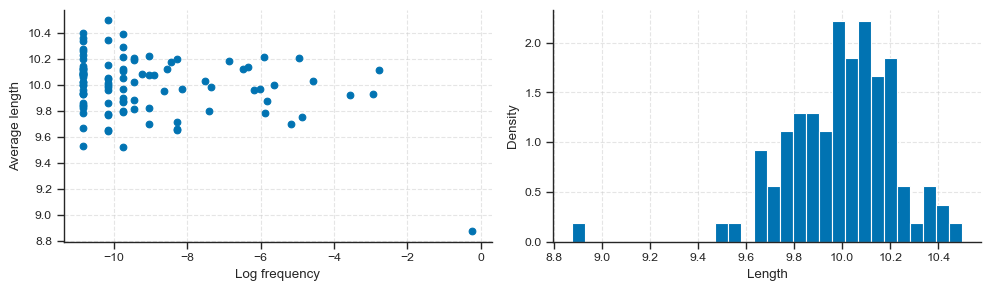

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# First subplot: Scatter plot of np.log(freq_m) vs. np.mean(wm_m, axis=0)
axes[0].scatter(np.log(freq_m), np.mean(wm_m, axis=0))
axes[0].set_xlabel('Log frequency')
axes[0].set_ylabel('Average length')
axes[0].grid(alpha=0.5, linestyle='--')

# Second subplot: Density plots
axes[1].grid(alpha=0.5, linestyle='--')
axes[1].hist(np.mean(wm_m, axis=0), bins=30, density=True, alpha=1)
# axes[1].hist(np.random.uniform(0,20, 100), bins=30, density=True, alpha=1)
# sns.kdeplot(np.random.gamma(shape=9, scale=0.5, size=10000), label='gamma sample', linewidth=2, ax=axes[1])
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Density')

sns.despine()

# Show plot
plt.tight_layout()
plt.show()

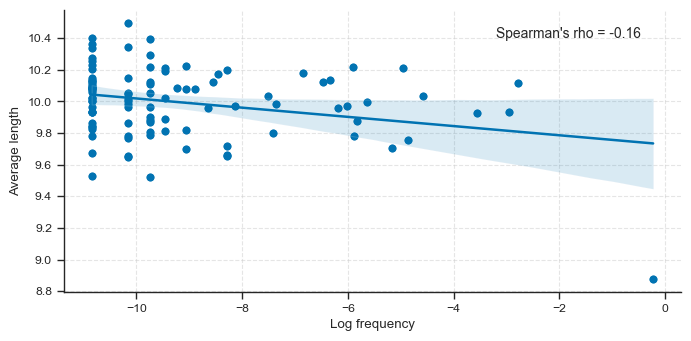

In [24]:
plt.figure(figsize=(7, 3.5))
plt.scatter(np.log(freq_m), np.mean(wm_m, axis=0))
sns.regplot(x=np.log(freq_m), y=np.mean(wm_m, axis=0))
## add spearman correlation     
plt.text(0.7, 0.9, f"Spearman's rho = {spearmanr(freq_m, np.mean(wm_m, axis=0)).correlation:.2f}", 
         transform=plt.gca().transAxes, fontsize=10)
plt.xlabel('Log frequency')
plt.ylabel('Average length')
sns.despine()
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
# Save the figure in png for word
plt.savefig('figures/scatterplot_one_run.png')
# Save the figure in pdf for print
plt.savefig('figures/scatterplot_one_run.pdf')
plt.show()

In [6]:
outs = []
wm_ms = []

for _ in trange(20):
    out, wm_m, _ = model(selection=0.5, mutation_rate=0.5, detailed=True)
    outs.append(out)
    wm_ms.append(wm_m)

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
# plt.hist(np.random.choice(wm_ms[0].flatten(), size=1000, replace=False), alpha=0.1, color='black', bins=100, label='Model output')
# # kdeplot with counts
# plt.hist(np.random.choice(wm_ms[0].flatten(), size=1000, replace=False), alpha=0.1, color='red', bins=100, label='Model output')
# # kdeplot(np.random.normal(4, 1, 10000))
# plt.show()

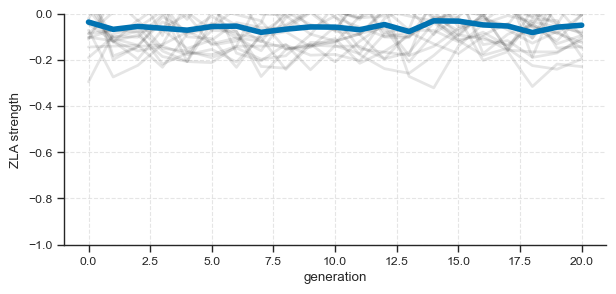

In [8]:
# plot out
plt.figure(figsize=(7, 3))
for _ in outs:
    plt.plot(_, alpha=0.1, color='black', linewidth=2)
plt.plot(np.mean(outs, axis=0),linewidth=4, alpha=1)
plt.xlabel('generation')
plt.ylabel('ZLA strength')
plt.ylim(-1, 0)
# plt.xlim(0, 20)
# make integer ticks
# plt.xticks(np.arange(0, 101, 2))
plt.grid(alpha=0.5, linestyle='--')
sns.despine()
plt.show()

In [9]:
selections = np.linspace(0.01, 1, 11)
mutation_rates = np.linspace(0.01, 1, 11)

results = np.zeros((len(selections), len(mutation_rates)))

# use tqdm
for i in trange(len(selections)):
    for j in range(len(mutation_rates)):
        res = []
        for _ in range(10):
            res.append(model(selections[i], mutation_rates[j]))

        results[i, j] = np.mean(res)

  0%|          | 0/11 [00:00<?, ?it/s]

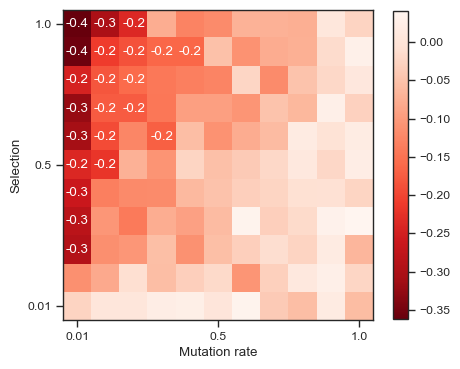

In [12]:
# plot the heatmap, but color cells if they are in between 0.1 and 0.5
plt.figure(figsize=(5, 5))
plt.imshow(results, cmap='Reds_r')
plt.xlabel('Mutation rate')
plt.ylabel('Selection')
# add xticks and yticks but display every 5th value
plt.xticks(np.arange(len(mutation_rates))[::5], np.round(mutation_rates[::5], 2))
plt.yticks(np.arange(len(selections))[::5], np.round(selections[::5], 2))
# reverse y axis ticks
plt.gca().invert_yaxis()
# small colorbar
plt.colorbar(shrink=0.8)
for i in range(len(selections)):
    for j in range(len(mutation_rates)):
        if  -0.107 >= np.round(results[i, j], 1) >= -0.466:
            plt.text(j, i, np.round(results[i, j], 1), ha='center', va='center', color='white')
plt.show()

In [13]:
n_agents_ = [10, 100, 1000, 10000]
n_meaning_ = [10, 100, 1000, 10000]

num_heatmaps = 10
results_all = np.zeros((num_heatmaps, len(n_agents_), len(n_meaning_)))

for k in range(num_heatmaps):
    for i in trange(len(n_agents_)):
        for j, n_meaning in enumerate(n_meaning_):
            results_all[k, i, j] = model(0.5, 0.5, n_meanings=n_meaning, n_agents=n_agents_[i])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [14]:

results_avg = np.mean(results_all, axis=0)

In [16]:
num_of_interactions = [10, 100, 1000, 10000, 100000]
 
results__ = defaultdict(list)
for i in trange(len(num_of_interactions)):
    for _ in range(100):
        results__[i].append(model(0.5, 0.5, num_encounters=num_of_interactions[i]))

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
num_of_interactions

[10, 100, 1000, 10000, 100000]

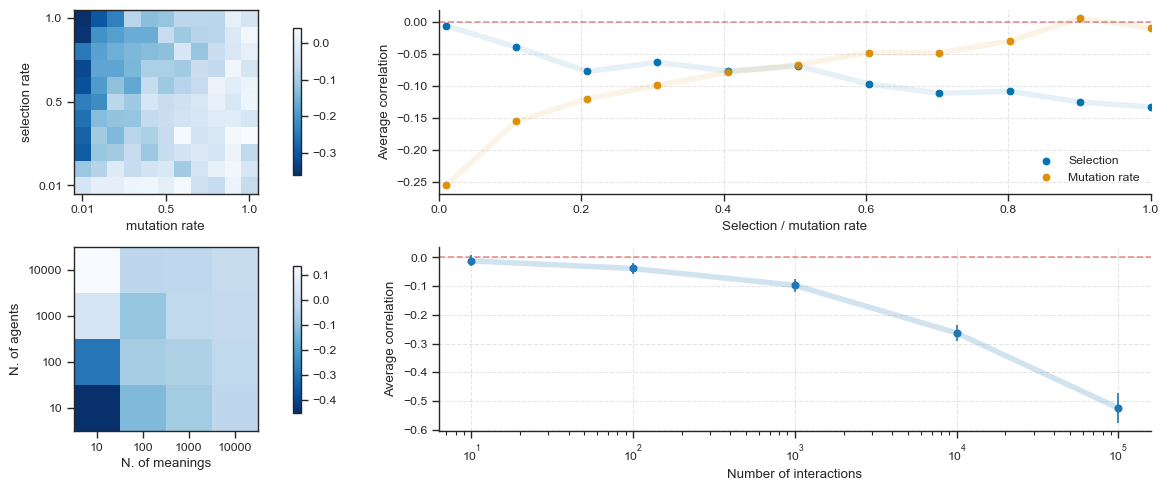

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 5))
# letter_subplots()

# Subplot 1: Heatmap
im1 = ax1.imshow(results, cmap='Blues_r')
ax1.set_xlabel('mutation rate')
ax1.set_ylabel('selection rate')
ax1.set_xticks(np.arange(len(mutation_rates))[::5])
ax1.set_xticklabels(np.round(mutation_rates[::5], 2))
ax1.set_yticks(np.arange(len(selections))[::5])
ax1.set_yticklabels(np.round(selections[::5], 2))
ax1.invert_yaxis()
fig.colorbar(im1, ax=ax1, shrink=0.8)

# Subplot 2: Scatter plot
ax2.scatter(selections, np.mean(results, axis=1), label='Selection')
ax2.plot(selections, np.mean(results, axis=1), alpha=0.1, linewidth=4)
ax2.scatter(mutation_rates, np.mean(results, axis=0), label='Mutation rate')
ax2.plot(mutation_rates, np.mean(results, axis=0), alpha=0.1, linewidth=4)
ax2.set_xlabel('Selection / mutation rate')
ax2.set_ylabel('Average correlation')
ax2.axhline(0, color='tab:red', linestyle='--', alpha=0.5)
ax2.legend(frameon=False)
sns.despine(ax=ax2)
ax2.grid(alpha=0.5, linestyle='--')
ax2.set_xlim(0, 1)

# Subplot 3: Heatmap
im2 = ax3.imshow(results_avg, cmap='Blues_r')
ax3.set_xlabel('N. of meanings')
ax3.set_ylabel('N. of agents')
ax3.set_xticks(np.arange(len(n_meaning_)))
ax3.set_xticklabels(n_meaning_)
ax3.set_yticks(np.arange(len(n_agents_)))
ax3.set_yticklabels(n_agents_)
ax3.invert_yaxis()
fig.colorbar(im2, ax=ax3, shrink=0.8)

# Subplot 4: Mean per number of interactions
means = [np.mean(results__[i]) for i in range(len(num_of_interactions))]
sems = [stats.sem(results__[i]) for i in range(len(num_of_interactions))]
ci_multiplier = stats.t.ppf(0.975, [len(results__[i])-1 for i in range(len(num_of_interactions))])
ci = [sem * multiplier for sem, multiplier in zip(sems, ci_multiplier)]
ax4.axhline(0, color='tab:red', linestyle='--', alpha=0.5)
ax4.plot(num_of_interactions, means, color='tab:blue', linewidth=4, alpha=0.2)
ax4.errorbar(num_of_interactions, means, yerr=ci, fmt='o', color='tab:blue')
ax4.grid(alpha=0.5, linestyle='--')
ax4.set_xticks(num_of_interactions)
ax4.set_xticklabels([str(i) for i in num_of_interactions])
ax4.set_xscale('log')
sns.despine(ax=ax4)
ax4.set_xlabel('Number of interactions')
ax4.set_ylabel('Average correlation')

plt.tight_layout()
# Save the figure in png for word
plt.savefig('model_output_v2.png', dpi=300, bbox_inches='tight')
# Save the figure in pdf for print
plt.savefig('model_output_v2.pdf', bbox_inches='tight')
plt.show()